#                                              Brain Tumor MRI Classification

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

import zipfile
zip_ref= zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf                  # Used for building Deep Learning models
import matplotlib.pyplot as plt          # Both matplotlib and seaborn are used for data visualization
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix    
# Used to know how well our classification model performs

import os                       # Used for tasks like creating, deleting ,moving, renaming and accessing files and directories
import cv2                      # Used to preprocess images before they are fed to model 

from tensorflow import keras
from keras import Sequential                     # Sequential is used for building linear stack of layers 
from keras.utils.np_utils import to_categorical  # Used to one-hot encode target data for when using categorical crossentrophy loss function
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
# Dense layer is a fully connected layer, where every neuron in the layer is connected to every neuron in the 
# preceding and subsequent layers

# Conv2D layer is a convolutional layer that performs 2D convolution on the input data. 
# It applies a set of filters to the input data and produces a set of output feature maps. Often used for image recognition tasks.

# MaxPooling is a pooling layer that applies a maximum pooling operation on the input data. It partitions the input data into 
# non-overlapping rectangles and takes the maximum value from each rectangle. This results in a reduction of the spatial dimensions of the input data.

# Flatten layer is used to reshape the input data into a 1D array. 
# This is typically done before passing the data through a dense layer.

from keras.layers import  Dropout
#Dropout layer is used to reduce overfitting by turning the nodes off randomly

from keras.callbacks import ModelCheckpoint
# ModelCheckpoint is used to save weights of model during training at certain intervals or when it meets certain performance mark

# Visualizing Training data

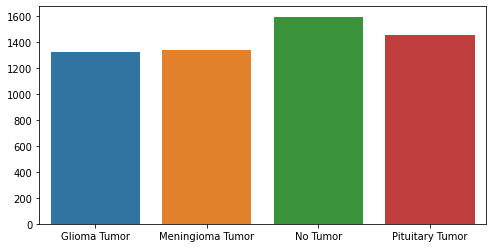

In [9]:
glioma = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Training\\glioma")
meningioma = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Training\\meningioma")
no_tumor = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Training\\notumor")
pituitary = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Training\\pituitary")

Labels = ['Glioma Tumor','Meningioma Tumor','No Tumor','Pituitary Tumor']
values = [len(glioma),len(meningioma),len(no_tumor),len(pituitary)]

plt.figure(figsize = (8,4))
sns.barplot(x= Labels , y=values)
plt.show()

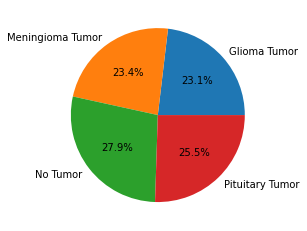

In [8]:
plt.pie(values, labels = Labels,autopct = '%1.1f%%')
plt.show()                                                    # Here we can see that the image dataset is almost balanced 

# Loading the data , preprocessing it and splitting it for training and validation

In [18]:
DIR_Path = "/content/Training/"
CLASSES = ['glioma','meningioma','notumor','pituitary']       # Classes of our data. Here we have four classes.

In [19]:
data = []

def loading_data():
  for category in CLASSES:                                                  # This function is used to extract images and their
    path = os.path.join(DIR_Path,category)                                  # labels from Training Directory and store them 
    class_num = CLASSES.index(category)                                     # data list as a list of images and their respective 
    for img in os.listdir(path):                                            # labels. Here the images are converted to grayscale
      img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)   # and their size is taken as (200,200)
      new_array = cv2.resize(img_array,(200,200))
      data.append([new_array,class_num])

loading_data()                                                  

In [20]:
X = []
y = []
for image,label in data:                         # This function stores images in X list and their labels in y list
  X.append(image)
  y.append(label)

X=np.array(X).reshape(-1,200,200)                # Here the first dimension is number of samples, second and third are for 
print(X.shape)                                   # height and width of images. Here we are making sure that the dataset has 
                                                 # correct shape for model to be able to process it.

(5712, 200, 200)


In [21]:
X=X/255.0                                     # Here we are feature scaling the images pixel range from [0,255] to [0,1]
X=X.reshape(-1,200,200,1)                     # Here the fourth dimension is the number of channels. 1 is for grey while 
print(X.shape)                                # 3 is for rgb channel. Here we are using 1 channel (i.e. grey)

(5712, 200, 200, 1)


In [22]:
y = to_categorical(y , num_classes=4)         # Here we have 4 classes that are represented as integers from 0 to 3.
print(y.shape)                                # to_categorical is used to one-hot encode this classes and this function converts
                                              # these integers to a binary matrix with a shape of (n_samples,n_classes)

(5712, 4)


In [24]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

print("X train shape : ",X_train.shape)              # Here we split the training dataset and we use 80% for training
print("X test shape : ",X_val.shape)                 # and rest 20% for validation
print("y train shape : ",y_train.shape)
print("y test shape : ",y_val.shape)

X train shape :  (4569, 200, 200, 1)
X test shape :  (1143, 200, 200, 1)
y train shape :  (4569, 4)
y test shape :  (1143, 4)


# CNN Model 

In [27]:
#model

model= Sequential()

model.add(Conv2D(32,kernel_size=(5,5),strides=1,padding="same",activation="relu",input_shape = (200,200,1)))
model.add(MaxPooling2D(pool_size=(2,2),padding = "valid"))
model.add(Dropout(0.3))

model.add(Conv2D(64,kernel_size=(3,3),strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),padding = "valid"))
model.add(Dropout(0.3))

model.add(Conv2D(64,kernel_size=(3,3),strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),padding = "valid"))
model.add(Dropout(0.3))

model.add(Conv2D(128,kernel_size=(3,3),strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),padding = "valid"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation = 'softmax'))

In [28]:
model.summary()
# Summary tells us about the layers used, their resultant output shape and the number of parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 50, 50, 64)       

In [29]:
model_checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/weights_improvement_model18-{epoch:02d}-{val_accuracy:.2f}.hdf5",
                                   monitor="val_accuracy",
                                   verbose =1, save_best_only = True,mode='max')
# Here we use model checkpoint to save model when the present validation accuracy is higher than previous one. Verbose means to 
# show the saving done

In [30]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics = ['accuracy'])
# Adam is an optimization algorithm for updating the parameters of a neural network. It is stochastic gradient descent 
# optimization algorithm.

# categorical_crossentrophy is used as loss function when we have one-hot encoded the output classes

In [31]:
history1 = model.fit(X_train,y_train,batch_size=32 ,epochs=30,validation_data=(X_val,y_val),callbacks=[model_checkpoint])
# Here we are training the model in batches of 32 images and validating them in validation data.

Epoch 1/30
143/143 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6006
Epoch 1: val_accuracy improved from -inf to 0.58443, saving model to /content/drive/MyDrive/weights_improvement_model18-01-0.58.hdf5
143/143 [==============================] - 18s 65ms/step - loss: 0.9188 - accuracy: 0.6006 - val_loss: 0.8867 - val_accuracy: 0.5844
Epoch 2/30
143/143 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7881
Epoch 2: val_accuracy improved from 0.58443 to 0.65529, saving model to /content/drive/MyDrive/weights_improvement_model18-02-0.66.hdf5
143/143 [==============================] - 8s 57ms/step - loss: 0.5537 - accuracy: 0.7881 - val_loss: 0.7910 - val_accuracy: 0.6553
Epoch 3/30
142/143 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.8228
Epoch 3: val_accuracy improved from 0.65529 to 0.74191, saving model to /content/drive/MyDrive/weights_improvement_model18-03-0.74.hdf5
143/143 [==============================] -

# Plotting accuracy and loss of model of training and validation data

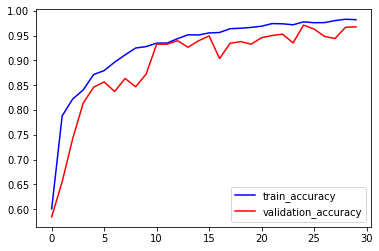

In [32]:
plt.plot(history1.history['accuracy'],color='blue',label='train_accuracy')
plt.plot(history1.history['val_accuracy'],color='red',label='validation_accuracy')
plt.legend()
plt.show()
# Here we are plotting the training and validation accuracy for 30 epochs.
# Here we can that at 25th epoch we get training accuracy as 0.9777 and validation accuracy as 0.9711 .This is the highest
# validation accuracy we get for our model when we run for 30 epochs.

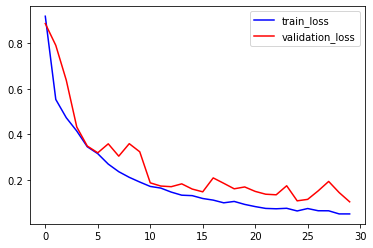

In [33]:
plt.plot(history1.history['loss'],color='blue',label='train_loss')
plt.plot(history1.history['val_loss'],color='red',label='validation_loss')
plt.legend()
plt.show()
# Here we are plotting the training and validation loss for 30 epochs.
# Here we can that at 25th epoch we get training loss as 0.0643 and validation loss as 0.1088 .This is the lowest
# validation loss we get for our model when we run for 30 epochs.

# Classification report and confusion matrix for validation data

In [59]:
from sklearn.metrics import classification_report
from keras.models import load_model
classes_data = sorted(os.listdir(DIR_Path))

m1 = load_model("/content/drive/MyDrive/weights_improvement_model18-25-0.97.hdf5")
predict = m1.predict(X_val)
classes_x = np.argmax(predict,axis=1)                                     # Here we are printing classification report for our
                                                                          # validation data.
Y_val2=np.argmax(y_val,axis=1)

print(classification_report(Y_val2,classes_x,target_names=classes_data))

36/36 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       288
  meningioma       0.97      0.91      0.94       265
     notumor       0.98      0.99      0.98       291
   pituitary       0.98      1.00      0.99       299

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



In [60]:
df = pd.DataFrame(confusion_matrix(Y_val2,classes_x),index = ['True_glioma','True_meningioma','True_notumor','True_pituitary'],
                  columns= ['Pred_glioma','Pred_meningioma','Pred_notumor','Pred_pituitary'])
df.style.background_gradient(cmap='Blues')

,Pred_glioma,Pred_meningioma,Pred_notumor,Pred_pituitary
True_glioma,283,5,0,0
True_meningioma,13,242,5,5
True_notumor,0,2,287,2
True_pituitary,0,1,0,298


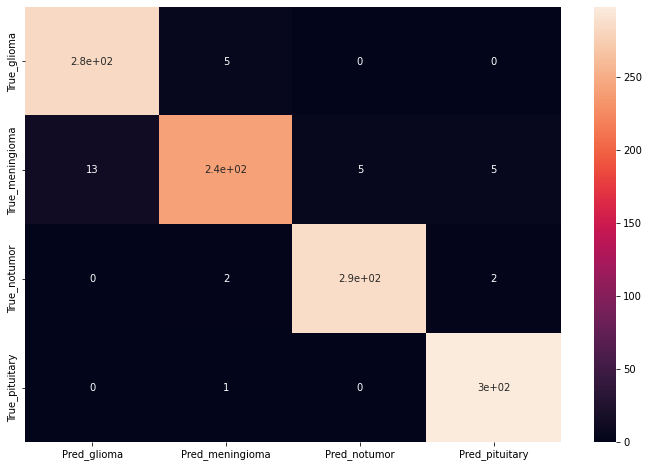

In [61]:
plt.figure(figsize=(12,8))
sns.heatmap(df,annot = True)

# Testing on unseen data

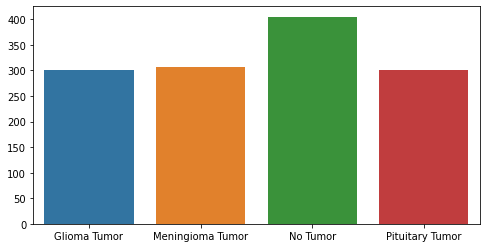

In [10]:
glioma = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Testing\\glioma")
meningioma = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Testing\\meningioma")
no_tumor = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Testing\\notumor")
pituitary = os.listdir("C:\\Users\\Suraj Menon\\\Desktop\\archive\\Testing\\pituitary")

Labels = ['Glioma Tumor','Meningioma Tumor','No Tumor','Pituitary Tumor']
values = [len(glioma),len(meningioma),len(no_tumor),len(pituitary)]

plt.figure(figsize = (8,4))
sns.barplot(x= Labels , y=values)
plt.show()

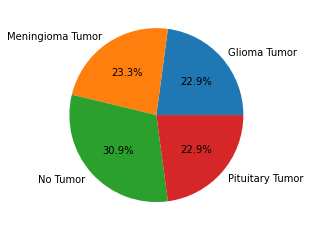

In [11]:
plt.pie(values, labels = Labels,autopct = '%1.1f%%')
plt.show()

In [35]:
Test_dir = "/content/Testing/"
Category = ['glioma','meningioma','notumor','pituitary']

test_data = []
def load_test_data():
  for i in Category:
    path = os.path.join(Test_dir,i)
    class1_num = Category.index(i)
    for img in os.listdir(path):
      img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
      new_arr = cv2.resize(img_arr,(200,200))
      test_data.append([new_arr,class1_num])

load_test_data()

X_test = []
y_test = []

for image,label in test_data:
  X_test.append(image)
  y_test.append(label)

X_test = np.array(X_test).reshape(-1,200,200)
X_test = X_test/255.0
X_test = X_test.reshape(-1,200,200,1)

y_test = to_categorical(y_test,num_classes=4)

In [36]:
print(X_test.shape)
print(y_test.shape)

(1311, 200, 200, 1)
(1311, 4)


# Classification report and confusion matrix for unseen test data

In [37]:
from sklearn.metrics import classification_report
from keras.models import load_model
classes_data_test = sorted(os.listdir(Test_dir))

m1 = load_model("/content/drive/MyDrive/weights_improvement_model18-25-0.97.hdf5")
predict = m1.predict(X_test)
classes_x = np.argmax(predict,axis=1)

Y_val2=np.argmax(y_test,axis=1)

print(classification_report(Y_val2,classes_x,target_names=classes_data_test))

41/41 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96       300
  meningioma       0.97      0.88      0.92       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.96      0.96      1311



In [58]:
df = pd.DataFrame(confusion_matrix(Y_val2,classes_x),index = ['True_glioma','True_meningioma','True_notumor','True_pituitary'],
                  columns= ['Pred_glioma','Pred_meningioma','Pred_notumor','Pred_pituitary'])
df.style.background_gradient(cmap='Blues')

,Pred_glioma,Pred_meningioma,Pred_notumor,Pred_pituitary
True_glioma,291,8,0,1
True_meningioma,18,269,9,10
True_notumor,0,0,405,0
True_pituitary,0,0,0,300


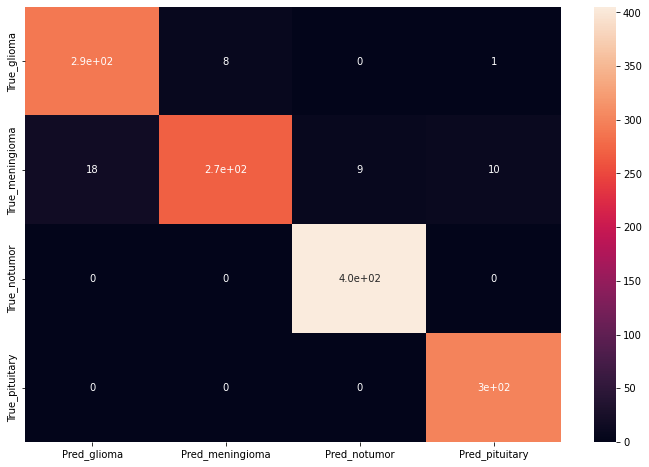

In [49]:
plt.figure(figsize=(12,8))
sns.heatmap(df,annot = True)